## Importing Dataset from robots.ox.ac.uk website

In [2]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz && mkdir -p ~/data/flowers
!tar -xzf 102flowers.tgz -C ~/data/flowers/
!rm 102flowers.tgz
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!mv setid.mat ~/data/flowers/setid.mat
!mv imagelabels.mat ~/data/flowers/imagelabels.mat

--2023-11-30 03:23:00--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz [following]
--2023-11-30 03:23:00--  https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M   224MB/s    in 1.5s    

2023-11-30 03:23:02 (224 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]

URL transformed to HTTPS due to an HSTS policy
--2023-11-30 03:23:08-

In [3]:
!ls ~/data/flowers

imagelabels.mat    imagelabels.mat.2  jpg    setid.mat	  setid.mat.2
imagelabels.mat.1  imagelabels.mat.3  model  setid.mat.1  setid.mat.3


In [4]:
cd ~/data/flowers/

/root/data/flowers


In [96]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.io
import matplotlib.pyplot as plt
import os
%matplotlib inline
import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB6, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, AveragePooling2D, Dropout, Dense, Convolution2D, MaxPooling2D, Flatten 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [21]:
CLASS_NUM            = 102
IMG_SIZE             = 128
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [7]:
# Import to a python dictionary
labels_mat = scipy.io.loadmat('imagelabels.mat')
split_mat = scipy.io.loadmat('setid.mat')

In [8]:
# Look at the dictionary items
labels_mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 '__globals__': [],
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}

In [9]:
labels_mat['labels']

array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)

In [10]:
labels = labels_mat['labels'][0]

In [11]:
labels # 1D array now

array([77, 77, 77, ..., 62, 62, 62], dtype=uint8)

In [12]:
labels.min() # we need to reduce each number by 1, so classes starts from 0

1

In [13]:

labels = labels - 1

In [14]:
idmat = scipy.io.loadmat('setid.mat')
idmat.keys()
train_num = idmat['trnid']
test_num = idmat['tstid']
valid_num = idmat['valid']
train_num = train_num[0]
test_num = test_num[0]
valid_num = valid_num[0]
print(len(train_num))
print(len(test_num))
print(len(valid_num))

1020
6149
1020


In [15]:
print(train_num)
print(test_num)
print(valid_num)

[6765 6755 6768 ... 8026 8036 8041]
[6734 6735 6737 ... 8044 8045 8047]
[6773 6767 6739 ... 8028 8008 8030]


In [16]:
train = []
test = []
valid = []

for i in range(len(train_num)):
  dir = 'jpg/image' + '_' + str(train_num[i]).zfill(5)+ '.jpg'  # To read images to image folder
  image = cv2.imread(dir)
  new_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
  new_image = new_image/255.0
  train.append(new_image)
X_train = np.asarray(train, dtype = np.float32)
# x_train.reshape(256,256,1)

for i in range(len(test_num)):
  dir = 'jpg/image' + '_' + str(test_num[i]).zfill(5) + '.jpg'
  image = cv2.imread(dir)
  new_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
  new_image = new_image/255.0
  test.append(new_image)
X_test = np.asarray(test, dtype = np.float32)

for i in range(len(valid_num)):
  dir = 'jpg/image' + '_' + str(valid_num[i]).zfill(5) + '.jpg'
  image = cv2.imread(dir)
  new_image  = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
  new_image = new_image/255.0
  valid.append(new_image)
X_valid = np.asarray(valid, dtype=np.float32)
# valid.reshape(256,256,1)

In [17]:
train_label = []
for i in range(len(train_num)):
  train_label.append(labels[train_num[i]-1])
train_label = np.asarray(train_label, dtype = np.float32)

test_label = []
for i in range(len(test_num)):
  test_label.append(labels[test_num[i] - 1])
test_label = np.asarray(test_label, dtype = np.float32)

valid_label = []
for i in range(len(valid_num)):
  valid_label.append(labels[valid_num[i] - 1])
valid_label = np.asarray(valid_label, dtype = np.float32)

from keras.utils import to_categorical 
y_train = to_categorical(train_label)  # train_label
y_test = to_categorical(test_label)  # test_label
y_valid = to_categorical(valid_label)  # valid_label

We notice that the test is 6149 image and train is 1020. It would make sense if we reversed it

In [18]:
X_temp = X_train 
y_temp = y_train
X_train = X_test
y_train = y_test
X_test = X_train
y_test = y_train


In [125]:
classifier = Sequential() 
classifier.add(Convolution2D(64, 3, 3, input_shape=input_shape, activation = 'relu'))  # No. of filter maps
classifier.add(MaxPooling2D(pool_size = (2, 2)))  # It will reduce the size of the feature maps (it will devide it by 2)
classifier.add(Dropout(0.3))
classifier.add(Convolution2D(128, 3, 3, activation = 'relu')) # no. of featuer detectors, dimensions of feature detectors and activation function
classifier.add(MaxPooling2D(pool_size=(2, 2)))  # Will reduce the size of feature maps
classifier.add(Dropout(0.5))
classifier.add(Flatten())  # Contains the information of the spatial structure
# Step 4 - Fully connected layer
# Full Connection 
# Hidden Layer
classifier.add(Dense(512, activation = 'relu'))  # Rectifier activation function (adds hidden layer to cnn)
# Output Layer
classifier.add(Dense(102, activation = 'softmax'))  # Sigmoid Activation function



In [126]:
classifier.summary()


Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 42, 42, 64)        1792      
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 21, 21, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_71 (Dropout)        (None, 21, 21, 64)        0         
                                                                 
 conv2d_76 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 3, 3, 128)         0         
 ng2D)                                                           
                                                                 
 dropout_72 (Dropout)        (None, 3, 3, 128)       

In [127]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=3)
train_cb = ModelCheckpoint('model/', save_best_only=True)

history = classifier.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs=40, callbacks=[early_stop, train_cb])

Epoch 1/40


2023-11-30 04:06:43.110985: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_49/dropout_71/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


193/193 [==============================] - 4s 15ms/step - loss: 3.9777 - accuracy: 0.0886 - val_loss: 3.8199 - val_accuracy: 0.0912
Epoch 2/40
193/193 [==============================] - 2s 12ms/step - loss: 3.2101 - accuracy: 0.1971 - val_loss: 3.3939 - val_accuracy: 0.1647
Epoch 3/40
193/193 [==============================] - 2s 12ms/step - loss: 2.7708 - accuracy: 0.2732 - val_loss: 2.9984 - val_accuracy: 0.2255
Epoch 4/40
193/193 [==============================] - 2s 12ms/step - loss: 2.4444 - accuracy: 0.3570 - val_loss: 2.7189 - val_accuracy: 0.3020
Epoch 5/40
193/193 [==============================] - 3s 17ms/step - loss: 2.1992 - accuracy: 0.4074 - val_loss: 2.5727 - val_accuracy: 0.3324
Epoch 6/40
193/193 [==============================] - 2s 12ms/step - loss: 2.0064 - accuracy: 0.4409 - val_loss: 2.4120 - val_accuracy: 0.3618
Epoch 7/40
193/193 [==============================] - 2s 12ms/step - loss: 1.8385 - accuracy: 0.4819 - val_loss: 2.3565 - val_accuracy: 0.4049
Epoch 8/40

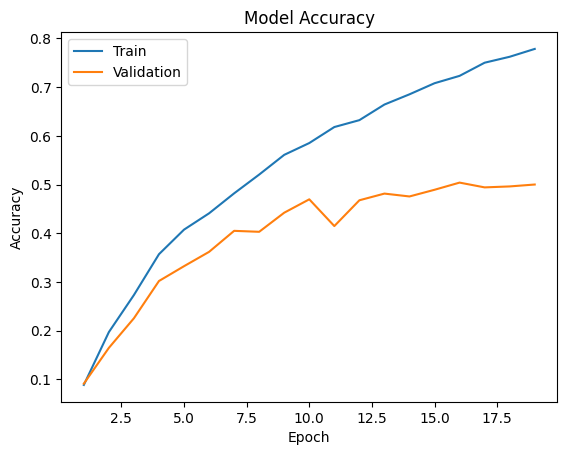

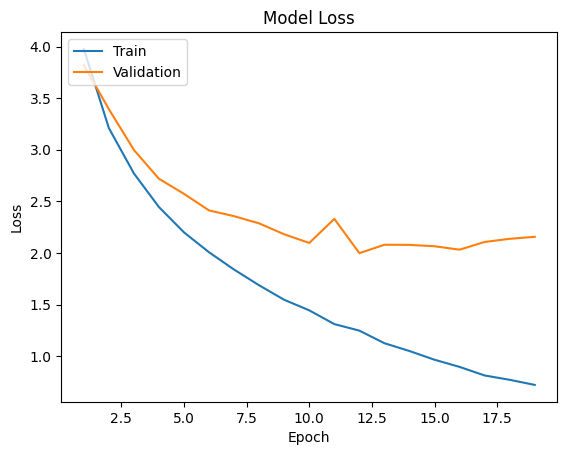

In [130]:
epochRange = range(1,20)
plt.plot(epochRange,history.history['accuracy'])
plt.plot(epochRange,history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

plt.plot(epochRange,history.history['loss'])
plt.plot(epochRange,history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

## 0.93 Accuracy

In [132]:
classifier.evaluate(X_test, y_test) 

193/193 [==============================] - 1s 4ms/step - loss: 0.2768 - accuracy: 0.9392


[0.27677568793296814, 0.9391770958900452]